In [1]:
import sys
import numpy as np
import pandas as pd
from pandas_datareader import data 
import matplotlib.pyplot as plt
import datetime
import plotly.graph_objects as go

In [2]:
#Comprise list of pharma companies from the index
companies_dict = {'JOHNSON & JOHNSON':'JNJ',
'UNITEDHEALTH GROUP INC':'UNH',
'PFIZER INC':'PFE',
'ABBVIE INC':'ABBV',
'ELI LILLY':'LLY',
'MERCK & CO INC':'MRK',
'THERMO FISHER SCIENTIFIC INC':'TMO',
'ABBOTT LABORATORIES':'ABT',
'BRISTOL MYERS SQUIBB':'BMY',
'DANAHER CORP':'DHR',
'MEDTRONIC PLC':'MDT',
'AMGEN INC':'AMGN',
'CVS HEALTH CORP':'CVS',
'ANTHEM INC':'ANTM',
'CIGNA CORP':'CI',
'INTUITIVE SURGICAL INC':'ISRG',
'STRYKER CORP':'SYK',
'GILEAD SCIENCES INC':'GILD',
'ZOETIS INC CLASS A':'ZTS',
'BECTON DICKINSON':'BDX',
'REGENERON PHARMACEUTICALS INC':'REGN',
'VERTEX PHARMACEUTICALS INC':'VRTX',
'EDWARDS LIFESCIENCES CORP':'EW',
'BOSTON SCIENTIFIC CORP':'BSX',
'HUMANA INC':'HUM',
'HCA HEALTHCARE INC':'HCA',
'MODERNA INC':'MRNA',
'MCKESSON CORP':'MCK',
'CENTENE CORP':'CNC',
'IQVIA HOLDINGS INC':'IQV',
'ILLUMINA INC':'ILMN',
'BAXTER INTERNATIONAL INC':'BAX',
'AGILENT TECHNOLOGIES INC':'A',
'DEXCOM INC':'DXCM',
'IDEXX LABORATORIES INC':'IDXX',
'BIOGEN INC':'BIIB',
'RESMED INC':'RMD',
'METTLER TOLEDO INC':'MTD',
'CERNER CORP':'CERN',
'ZIMMER BIOMET HOLDINGS INC':'ZBH',
'AMERISOURCEBERGEN CORP':'ABC',
'LABORATORY CORPORATION OF AMERICA':'LH',
'WEST PHARMACEUTICAL SERVICES INC':'WST',
'STERIS':'STE',
'ALIGN TECHNOLOGY INC':'ALGN',
'WATERS CORP':'WAT',
'HOLOGIC INC':'HOLX',
'PERKINELMER INC':'PKI',
'CATALENT INC':'CTLT',
'MOLINA HEALTHCARE INC':'MOH',
'QUEST DIAGNOSTICS INC':'DGX',
'COOPER INC':'COO',
'CARDINAL HEALTH INC':'CAH',
'BIO TECHNE CORP':'TECH',
'VIATRIS INC':'VTRS',
'INCYTE CORP':'INCY',
'TELEFLEX INC':'TFX',
'USD CASH':'USD',
'HENRY SCHEIN INC':'HSIC',
'ABIOMED INC':'ABMD',
'CHARLES RIVER LABORATORIES INTERNA':'CRL',
'BIO RAD LABORATORIES INC CLASS A':'BIO',
'ORGANON':'OGN',
'UNIVERSAL HEALTH SERVICES INC CLAS':'UHS',
'DENTSPLY SIRONA INC':'XRAY',
'DAVITA INC':'DVA'}
symbols, names = np.array(sorted(companies_dict.items())).T

quotes = []

In [3]:
#set the data aggregation
data_source = 'yahoo'
start_date = '2021/05/15' 
end_date = '2022/05/15'
df = data.DataReader(list(companies_dict.values()),
    data_source,start_date,end_date)

In [4]:
#choose parameters and features
stock_open = np.array(df['Open']).T
stock_close = np.array(df['Close']).T 
variation = stock_close - stock_open

In [5]:
#preparing the model
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

c:\program files\jetbrains\python39\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\program files\jetbrains\python39\lib\site-packages\sklearn\covariance\_graph_lasso.py:316: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.822e-04
  warnings.warn(


GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

In [6]:
#setting up the clusters
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: ABMD, ALGN, ILMN
Cluster 2: A, ABC, BAX
Cluster 3: ABT, TECH, CNC, IQV, WAT
Cluster 4: ABBV, BSX, BMY, DVA, LLY, PFE
Cluster 5: BIO, CAH, CTLT, COO, CVS, DHR, JNJ, MRK, REGN, TMO, ZBH
Cluster 6: CRL, HSIC
Cluster 7: DXCM
Cluster 8: BIIB, EW, LH, RMD, UHS
Cluster 9: AMGN, ANTM, BDX, CERN, CI, GILD, HCA, HOLX, HUM, IDXX, INCY, ISRG, MDT, MTD, MRNA, OGN, PKI, STE, TFX, UNH, USD, VRTX, VTRS
Cluster 10: MCK, MOH, DGX
Cluster 11: SYK
Cluster 12: XRAY, WST, ZTS


In [45]:
from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

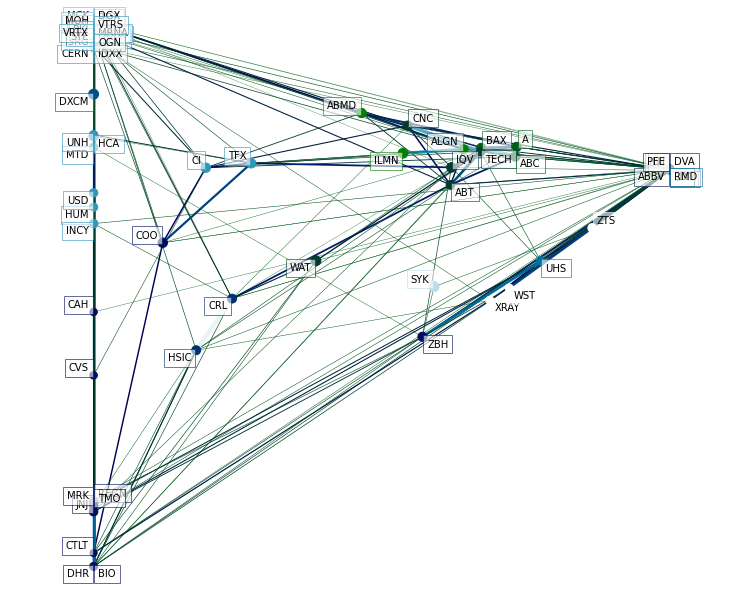

In [47]:
#visualiztion
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

demo1 = plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()

ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.ocean,
)

start_idx, end_idx = np.where(non_zero)

segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.ocean, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.ocean(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()